# Forward Error Correction Bit Error Analysis

This notebook is still a work in progress.

In [1]:
from pynq import Overlay
import numpy as np
import xsdfec

from helper_functions import *

ol = Overlay('bitstream/book_design.bit')

In [2]:
# Initialise encoder hardware
e_fec = ol.ldpc_encoder.sd_fec
e_dma_data = ol.ldpc_encoder.axi_dma_data
e_dma_ctrl = ol.ldpc_encoder.axi_dma_ctrl

e_ldpc_params = e_fec.available_ldpc_params()
add_multiple_ldpc_params(e_fec, e_ldpc_params)

# Initialise decoder hardware
d_fec = ol.ldpc_decoder.sd_fec
d_dma_data = ol.ldpc_decoder.axi_dma_data
d_dma_ctrl = ol.ldpc_decoder.axi_dma_ctrl

d_ldpc_params = d_fec.available_ldpc_params()
add_multiple_ldpc_params(d_fec, d_ldpc_params)

Adding LDPC code parameters to "ldpc_encoder/sd_fec" internal memory.

Status     Code ID    SC Offset  LA Offset  QC Offset  Code Name 
------     ------     ------     ------     ------     ------    
Loaded     0          0          0          0          docsis_short_encode
Loaded     1          2          2          21         docsis_medium_encode
Loaded     2          4          4          54         docsis_long_encode
Loaded     3          6          6          97         docsis_init_ranging_encode
Loaded     4          8          8          112        docsis_fine_ranging_encode
Adding LDPC code parameters to "ldpc_decoder/sd_fec" internal memory.

Status     Code ID    SC Offset  LA Offset  QC Offset  Code Name 
------     ------     ------     ------     ------     ------    
Loaded     0          0          0          0          docsis_short
Loaded     1          2          2          21         docsis_medium
Loaded     2          4          4          54         docsis_long
L

In [91]:
e_fec.CORE_BYPASS = 0
d_fec.CORE_BYPASS = 0

for i in range(len(e_tx_buffer)):
    e_tx_buffer[i] = amplitude_scaled[i]

set_ctrl_reg(e_dma_ctrl, e_ctrl_buffer, e_ctrl_params)
e_rx_buffer = transfer_data(e_dma_data, 
                            e_tx_buffer, 
                            e_rx_buffer, 
                            e_dma_ctrl, 
                            e_status_buffer)
check_encoding(e_fec, e_tx_buffer, e_rx_buffer, e_code_name, e_ldpc_params)

# Channel
hard_binary = serialise_data(e_rx_buffer)
signal = modulate(hard_binary)
signal_with_noise = add_noise(signal, 10)
llrs = soft_demodulate(signal_with_noise)
llrs_formatted = format_llrs(llrs)

# Decoder
j = 0
for i in range(len(d_tx_buffer)):
    d_tx_buffer[i] = llrs_formatted[j]
    j += 1

set_ctrl_reg(d_dma_ctrl, d_ctrl_buffer, d_ctrl_params)
d_rx_buffer = transfer_data(d_dma_data, 
                            d_tx_buffer, 
                            d_rx_buffer, 
                            d_dma_ctrl, 
                            d_status_buffer)

In [19]:
import time
from ipywidgets import IntProgress
from IPython.display import display

max_snr = 20
min_snr = -20

snr_runs = 300
max_count = snr_runs

f = IntProgress(min=0, max=max_count*3) # instantiate the bar
display(f) # display the bar

SNRs = []
BERs = []

e_code_names = ['docsis_short_encode', 'docsis_medium_encode', 'docsis_long_encode']
d_code_names = ['docsis_short', 'docsis_medium', 'docsis_long']
    
for cn in range(len(e_code_names)):
    e_buffers = set_ldpc_code(e_fec, e_code_names[cn])
    d_buffers = set_ldpc_code(d_fec, d_code_names[cn])

    e_code_id = e_ldpc_params.index(e_code_names[cn])
    e_ctrl_params = {'id' : 0, 'code' : e_code_id}

    d_code_id = d_ldpc_params.index(d_code_names[cn])
    d_ctrl_params = {'id' : 0, 
                     'max_iterations' : 32,
                     'term_on_no_change' : 1,
                     'term_on_pass' : 1, 
                     'include_parity_op' : 0,
                     'hard_op' : 1,
                     'code' : d_code_id}
    
    # Generate random data
    time = np.arange(0,len(e_buffers['tx'])/96,1/96)
    amplitude = (np.sin(time) * 128) + 128
    amplitude_scaled = amplitude.astype(int)
    for i in range(len(e_buffers['tx'])):
        e_buffers['tx'][i] = amplitude_scaled[i]

    for snr_run in range(snr_runs):
        SNR = 15 - ((max_snr-min_snr)/snr_runs)*snr_run

        set_ctrl_reg(e_dma_ctrl, e_buffers['ctrl'], e_ctrl_params)
        e_buffers['rx'] = transfer_data(e_dma_data, 
                                        e_buffers['tx'], 
                                        e_buffers['rx'], 
                                        e_dma_ctrl, 
                                        e_buffers['status'])

        # Channel
        hard_binary = serialise_data(e_buffers['rx'])
        signal = modulate(hard_binary)
        signal_with_noise = add_noise(signal, SNR)
        llrs = soft_demodulate(signal_with_noise)
        llrs_formatted = format_llrs(llrs)

        # Decoder
        j = 0
        for i in range(len(d_buffers['tx'])):
            d_buffers['tx'][i] = llrs_formatted[j]
            j += 1

        set_ctrl_reg(d_dma_ctrl, d_buffers['ctrl'], d_ctrl_params)
        d_buffers['rx'] = transfer_data(d_dma_data, 
                                        d_buffers['tx'], 
                                        d_buffers['rx'], 
                                        d_dma_ctrl, 
                                        d_buffers['status'])

        power_signal = 10*np.log10(np.var(signal))
        power_noise = 10*np.log10(np.mean(np.abs(signal - signal_with_noise)**2))
        measured_snr = power_signal - power_noise

        BER = calculate_ber(e_buffers['tx'], d_buffers['rx'])

        SNRs.append(measured_snr)
        BERs.append(BER)

        f.value += 1

IntProgress(value=0, max=900)

Created TX buffer for ldpc_encoder/sd_fec. Size: 105
Created RX buffer for ldpc_encoder/sd_fec. Size: 140
Created TX buffer for ldpc_decoder/sd_fec. Size: 1120
Created RX buffer for ldpc_decoder/sd_fec. Size: 105
Created TX buffer for ldpc_encoder/sd_fec. Size: 630
Created RX buffer for ldpc_encoder/sd_fec. Size: 743
Created TX buffer for ldpc_decoder/sd_fec. Size: 5940
Created RX buffer for ldpc_decoder/sd_fec. Size: 630
Created TX buffer for ldpc_encoder/sd_fec. Size: 1800
Created RX buffer for ldpc_encoder/sd_fec. Size: 2025
Created TX buffer for ldpc_decoder/sd_fec. Size: 16200
Created RX buffer for ldpc_decoder/sd_fec. Size: 1800


0 299
300 599
600 899


<function matplotlib.pyplot.show(*args, **kw)>

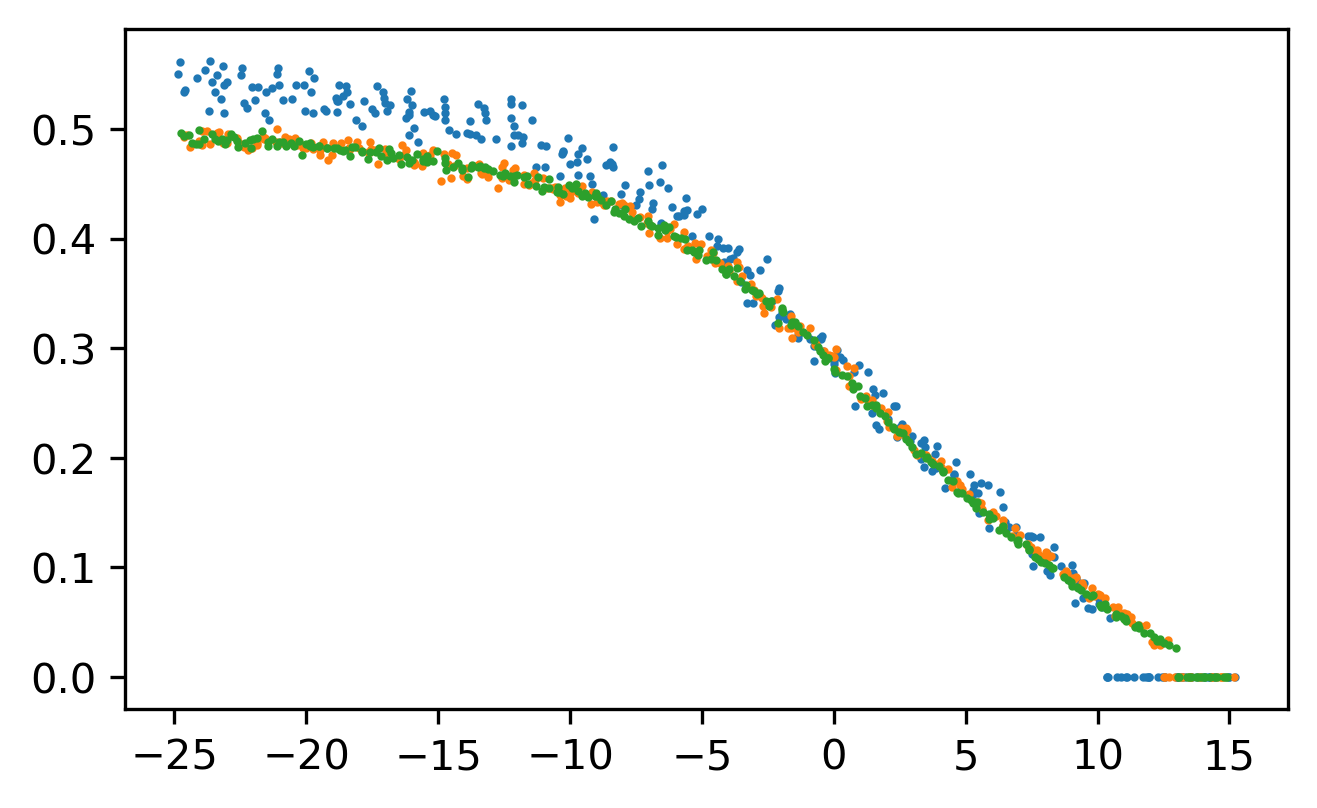

In [20]:
L = len(SNRs)
for i in range(3):
    start = int(i*(L/3))
    end = int(((i+1)*(L/3))-1)
    print(start, end)
    plt.scatter(SNRs[start : end], BERs[start:end], s=1)
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 300
plt.show